In [1]:
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyteomics import mzml

In [2]:
#for testing we use MC_1 

mcid = 1 #macrocycle id from the test set
em = 820.341866 #exact mass of macrocycle
em = em + 1.0008 #exact mass of protonated macrocycle


In [3]:
#using pyteomics to get spectrums out of mzml file / only keeps positive scans

def makespecstack(mcid):
    spectrum_stack = []
    with mzml.read('spectra\\MC_%s.mzML' %mcid) as reader:
        for spectrum in reader:
            if 'positive scan' in spectrum:
                spectrum_stack.append(spectrum)
    return spectrum_stack, mcid

spectrum_stack, mcid = makespecstack(str(mcid))

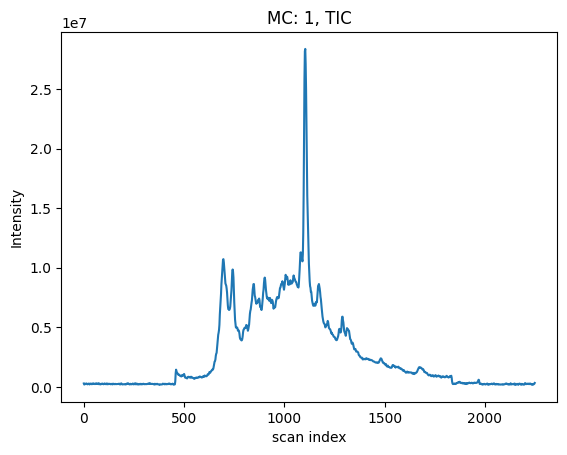

In [4]:
#plots tic / not necessary for estimated profile, but good to get an overview

def tic(spectrum_stack, mcid):
    times = [float(str(spectrum['scanList']['scan'][0]['scan start time']).split(' ')[0]) for spectrum in spectrum_stack]
    scanindex = [spectrum['index'] for spectrum in spectrum_stack]
    TIC = [spectrum['total ion current'] for spectrum in spectrum_stack]
    #plots
    fig, ax = plt.subplots(1,1)
    ax = sns.lineplot(x = scanindex, y = TIC) #scanindex is interchangable with times
    ax.set_xlabel('scan index')
    ax.set_ylabel('Intensity')
    plt.title('MC: ' + str(mcid) + ', TIC')
    plt.savefig('plots\\%s_tic.jpg' %mcid, bbox_inches = 'tight', dpi = 300)
    plt.show()
    #---uncomment until here

tic(spectrum_stack, mcid)

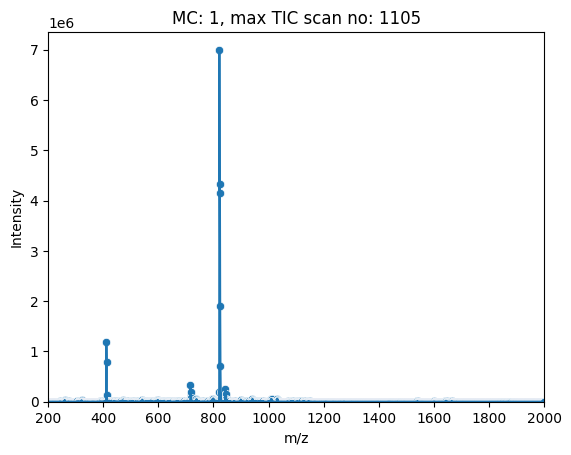

In [5]:
#plot spectrum with highest TIC \ also not neccessary for the extracted chromatogram, but gives an idea of major compound in the sample

def maxtic(spectrum_stack, mcid):
    scanindex = [spectrum['index'] for spectrum in spectrum_stack]
    TIC = [spectrum['total ion current'] for spectrum in spectrum_stack]
    maxscanindex = scanindex[TIC.index(max(TIC))] #find spectrum with highest TIC
    spectrum_number = maxscanindex #save the spectrum number as spectrum number
    #plot max spectrum
    for spectrum in spectrum_stack:
        if spectrum['index'] == spectrum_number: #find spectrum number with highest TIC
            # print(spectrum)
            # plot MS spectrum with highest TIC
            fig, ax = plt.subplots(1,1)
            ax = sns.scatterplot(data = spectrum, x = spectrum['m/z array'], y = spectrum['intensity array'])
            ax = sns.lineplot(data = spectrum, x = spectrum['m/z array'], y = spectrum['intensity array'])
            ax.set_xlabel('m/z')
            ax.set_ylabel('Intensity')
            plt.title('MC: ' + str(mcid) +', max TIC scan no: ' + str(spectrum['id'][5:]))
            plt.xlim(200,2000)
            plt.ylim(0,)
            plt.savefig('plots\\%s_maxticscan.jpg' %mcid, bbox_inches = 'tight', dpi = 300)
            plt.show()
    
    return None
maxtic(spectrum_stack, mcid)

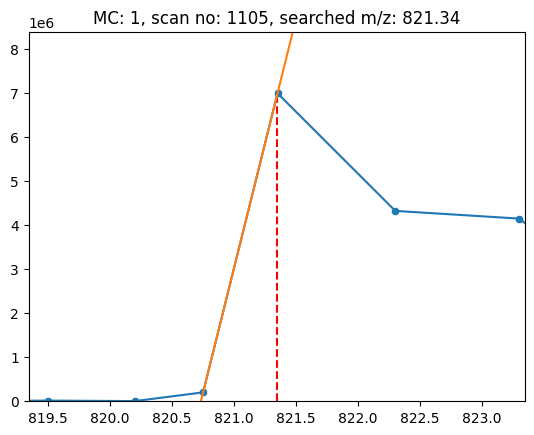

In [6]:
#function to generate extracted ion chromatogram

def extractedplot(em, spectrum_stack, mcid):
    eis = [] #list to collect extracted intensities
    times = []
    scanindex = []
    
    for spectrum in spectrum_stack:
            for idx, mz in enumerate(spectrum['m/z array']):
                if mz < em and spectrum['m/z array'][idx+1] > em: #find the two consecutive centroids that wrap the expected mass
                    # print(em)
                    # estimate intensity for em by linear regression of the two neighbouring centroids
                    x1 = mz
                    x2 = spectrum['m/z array'][idx+1]
                    y1 = spectrum['intensity array'][idx]
                    y2 = spectrum['intensity array'][idx+1]
                    # print(x1, x2, y1, y2)
                    slope, intercept, r, p, se = stats.linregress([x1, x2], [y1, y2])
                    # print(slope, intercept)
                    
                    def ei(x): #function to calculate the estimated intensity from the linear fit
                        ei = slope * x + intercept
                        return ei
                    # print(ei(x1), ei(x2))
                    eis.append(ei(em)) #save calculated intensity to list

            times.append(str(spectrum['scanList']['scan'][0]['scan start time']).split(' ')[0]) #see above
            scanindex.append(spectrum['index']) #see above

    # #plot for extracted ion chromatogram
    # fig, ax = plt.subplots(1,1)
    # ax = sns.scatterplot(x = scanindex, y = eis)
    # ax = sns.lineplot(x = scanindex, y = eis)
    # plt.title('MC: ' + str(mcid) + ', extracted: ' + str(em))
    # plt.savefig('plots\\%s_extracted_%s.jpg' %(mcid, round(em)), bbox_inches = 'tight', dpi = 300)
    # plt.show()
    #     #---------------- uncomment until here for extracted ion chromatogram

    #plot max plot
    
    maxeisscanindex = scanindex[eis.index(max(eis))]
    spectrum_number = maxeisscanindex
    #plot scan where extracted intensity is maximal
    for spectrum in spectrum_stack:
        if spectrum['index'] == spectrum_number:
            for idx, mz in enumerate(spectrum['m/z array']):
                if mz < em and spectrum['m/z array'][idx+1] > em:
                    # print(mz)
                    x1 = mz
                    x2 = spectrum['m/z array'][idx+1]
                    y1 = spectrum['intensity array'][idx]
                    y2 = spectrum['intensity array'][idx+1]
                    # print(x1, x2, y1, y2)
                    slope, intercept, r, p, se = stats.linregress([x1, x2], [y1, y2])
                    # print(slope, intercept)
                    def ei(x):
                        ei = slope * x + intercept
                        return ei

                    # print(spectrum['m/z array'])
                    # #plots
                    fig, ax = plt.subplots(1,1)
                    ax.vlines(em,0, ei(em), colors = 'red', linestyles= 'dashed')
                    ax = sns.scatterplot(data = spectrum, x = spectrum['m/z array'], y = spectrum['intensity array'])
                    ax = sns.lineplot(data = spectrum, x = spectrum['m/z array'], y = spectrum['intensity array'])
                    x = np.arange(200,2000, 0.01)
                    ax = sns.lineplot(x=x, y = ei(x))

                    plt.title('MC: ' + str(mcid) + ', scan no: ' + str(spectrum['id'][5:]) + ', searched m/z: ' + str('%.2f' %em))
                    plt.xlim((em-2),(em+2))
                    plt.ylim(0,max(spectrum['intensity array'])*1.2)
                    plt.savefig('plots\\%s_extracted_maxscan_%s.jpg' %(mcid, round(em)), bbox_inches = 'tight', dpi = 300)
                    plt.show()
                        # #---------------- uncomment until here for scan where extracted intensity is maximal

    return eis, times, scanindex, em

eis, times, scanindex, em = extractedplot(em, spectrum_stack, mcid)

I found 13 raw peaks
I found 4 unique peaks


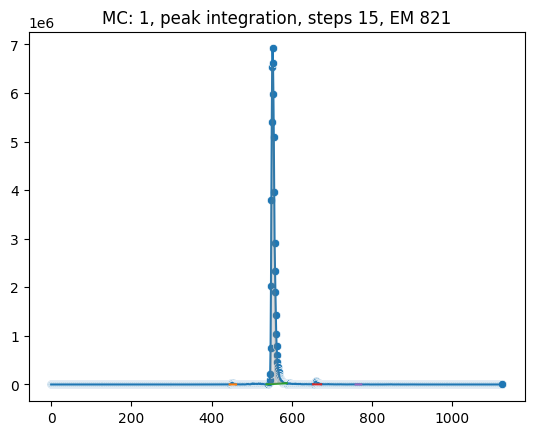

61227852.1483023

In [7]:
def peakfinding(eis, em):
    baseline_eqs = [] #list to save equations for baseline correction
    steps = 15 #how many steps the intensity has to increase consecutively in order for it to be recognized as peak

    #find peaks
    peak_counter = 0 #counts number of detected peaks
    peak_id_list = [] #list to save the indexes of where peaks start

    for idx,i in enumerate(eis[:-steps]): #loop through calculated estimated intensities (extracted ion chromatogram)
        for e in range(steps):
            # print(e)
            # print('old number: ' + str(eis[idx+e]))
            # print('new number: ' + str(eis[idx+e+1]))
            if (eis[idx+e] < eis[idx+e+1] and eis[idx] > 500) or (eis[idx]*4 < eis[idx+e] and eis[idx] > 500): #loop will continue if intensity increases (start of peak), or if intensity is 4-times higher than starting point, and as long as intensity is higher than 500
                # print(eis[idx])
                # if eis[idx+e] < eis[idx+e+1]:
                    # print('next intensity is larger than before')
                # if eis[idx+e]*4 < eis[idx+e+2]:
                    # print(idx)
                    # print('intensity is much larger than starting point')
                continue
                # print('going down')
                # print('only ' + str(e) + ' steps so far')
            else:
                break  
            # print('going up')
        if e == steps-1: #if the number of set steps is reached, the peak will be registered and saved to the list
            # print('it went up ' + str(e) + ' times')
            # print(idx)
            # print(i)
            peak_counter += 1
            peak_id_list.append(idx)

    print('I found ' + str(peak_counter) + ' raw peaks') #raw peaks refers to registered start of peaks

    peak_pair_list = [] #list to save start and end of peak


    #find end of peak
    for count, idx in enumerate(peak_id_list):
        
        x = 1
        
        #find maximum of peak by checking if the max of the next 15 plot points is higher than current intensity. The 15 is chosen to be tolerant to small plateaus, weird peak shapes, etc
        while eis[idx+x] < max(eis[idx+x:idx+x+15]):
            # print('Current intensity: ' + str(eis[idx+x]))
            # print('Im not at the max yet')
            x += 1
        #if the while loop is no longer satisfied, the max of the peak (according to the here applied rules) was reached
        # print('I found the max: ' + str(x) + ' ' + str(eis[idx+x]))

        x += 8 #tolerance after peak before starting to look for end of peak
        # print(eis[idx+x])

        #look for end of peak
        ## end of peak is when intensity is going up again (1) or decrease of intensity over 8 steps is less than 20 % (2) except the current intensity is still much higher than staring point (100 fold) (3)
        while (eis[idx] < eis[idx+x]): #(1)
            # print(np.mean(eis[idx+x-8:idx+x]))

            if (np.mean(eis[idx+x-8:idx+x])*0.8 < eis[idx+x]): #(2)
                # print('eis[idx+x]: ' + str(eis[idx+x]))
                # print('eis[idx]: ' + str(eis[idx]))

                if (eis[idx+x]/100 > eis[idx]): #(3)
                    x += 1
                    continue
                # print('peak is finished bc plateauing')
                break

            # print('peak is not finished')

            if idx+x == len(eis):
                # print('end of spectrum is reached')
                break
            x += 1
        # print('peak is finished bc number is smaller now')
        #save start and end of peak to peak pair list
        if len(peak_pair_list) == 0:
            peak_pair_list.append([idx, idx+x])
        else:
            if idx > peak_pair_list[-1][1]: #only save peak to peak list if there is no overlap with previous peak
                peak_pair_list.append([idx, idx+x])
                # print('peak is documented')

    print('I found ' + str(len(peak_pair_list)) + ' unique peaks')

    #integrate found peaks
    auc = 0 #area under curve
    for pair in peak_pair_list:
        temp_auc_list = [] #list to save auc for each peak individually
        # calculate base line to substract from auc
        x1 = pair[0]
        x2 = pair[1]
        y1 = eis[pair[0]]
        y2 = eis[pair[1]]
        # print(x1, x2, y1, y2)
        slope, intercept, r, p, se = stats.linregress([x1, x2], [y1, y2])
        # print(slope, intercept)
        baseline_eqs.append([slope, intercept]) #append calculated baseline equation to list for later plotting
        for i in range(x1, x2+1):
            if eis[i] - (i*slope + intercept) > 0: #only add points that are higher than the baseline
                temp_auc_list.append(eis[i] - (i*slope + intercept))
        auc += np.sum(temp_auc_list) #sum up all individual peaks

    #plot extracted chromatogram with integration (grey dashed area is integrated)
    fig, ax = plt.subplots(1,1)
    ax = sns.lineplot(x = [i for i in range(len(eis))], y = eis)
    for bbidx, peak in enumerate(peak_pair_list):
        ax = sns.lineplot(x = [idx for idx in peak], y = [eis[idx] for idx in peak])
        for point in np.arange(peak[0], peak[1], 2):
            ax.vlines(point, (baseline_eqs[bbidx][0]*point+baseline_eqs[bbidx][1]), eis[point], colors = ['grey'], linestyle = 'solid', linewidth = 0.2)
    ax = sns.scatterplot(x = [i for i in range(len(eis))], y = eis)
    #ax.hlines(0,0, len(eis), colors = 'black', linestyles= 'dashed') draws dashed baseline
    #plt.xlim(peak_pair_list[1][0]-50, peak_pair_list[1][1]+50) #zoom into peak
    plt.title('MC: %s, peak integration, steps %s, EM %s' %(mcid, str(steps), round(em)))
    plt.savefig('plots\\%s_peak_finding_%s.jpg' %(mcid, round(em)), bbox_inches = 'tight', dpi = 300)
    plt.show()
    #---------------- uncomment until here

    return auc

peakfinding(eis, em)

In [8]:
truncs = pd.read_csv('files/truncations.csv')
#display(truncs)
test_df = truncs.iloc[[0]] #only take the first row (MCID 1) for testing
#test_df = truncs #use this to run on all spectra
test_df


,ID,BB1,BB2,BB3,BB4,BB5,BB6,BB7,SMILES,mass,t1,t2
0,1,Mpa,Asp(CAPA),NaN,3amb,Val,Res1,L4,CC(C)[C@@H](C(NCCSCc1cccc(CSCCC(N[C@@H](CC(NCC...,820.341866,-,588.221866


,ID,BB1,BB2,BB3,BB4,BB5,BB6,BB7,SMILES,mass,t1,t2
0,1,Mpa,Asp(CAPA),NaN,3amb,Val,Res1,L4,CC(C)[C@@H](C(NCCSCc1cccc(CSCCC(N[C@@H](CC(NCC...,820.341866,-,588.221866


mass
0    820.341866
Name: mass, dtype: float64
820.341866


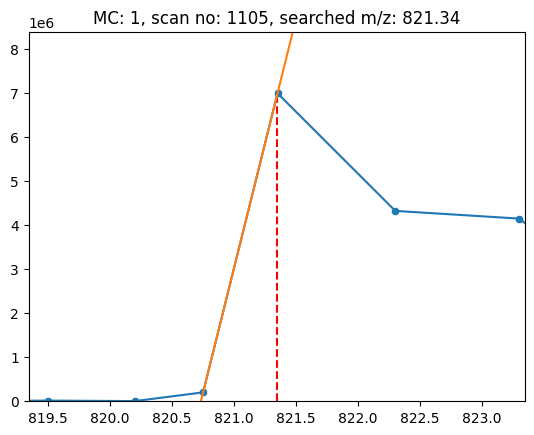

I found 13 raw peaks
I found 4 unique peaks


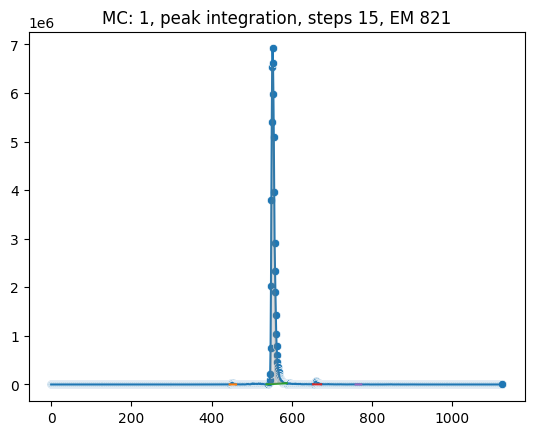

mass: 61227852.1483023
t1
0    -
Name: t1, dtype: object
-
t2
0    588.221866
Name: t2, dtype: float64
588.221866


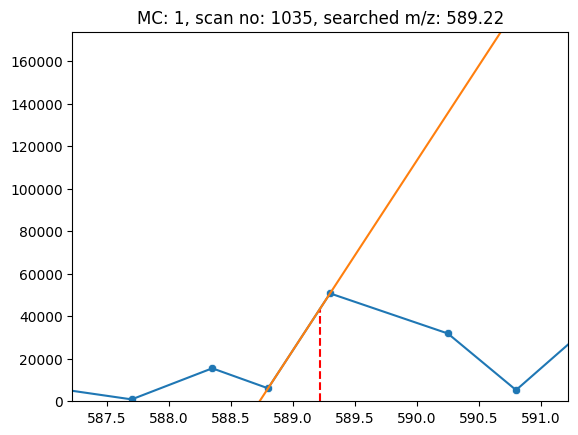

I found 2 raw peaks
I found 2 unique peaks


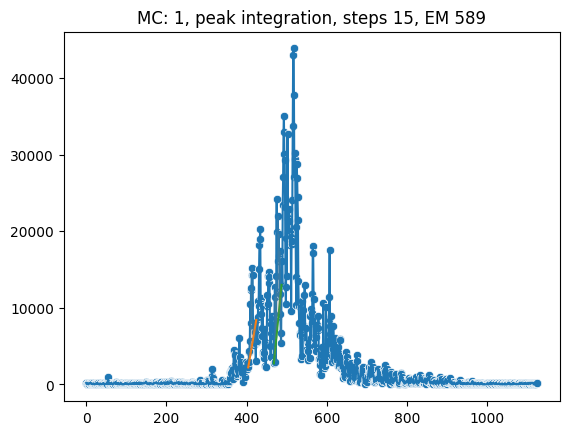

t2: 176723.71851430726


,ID,BB1,BB2,BB3,BB4,BB5,BB6,BB7,SMILES,mass,t1,t2,mass_abs,t2_abs
0,1,Mpa,Asp(CAPA),NaN,3amb,Val,Res1,L4,CC(C)[C@@H](C(NCCSCc1cccc(CSCCC(N[C@@H](CC(NCC...,820.341866,-,588.221866,6.122785e+07,176723.718514


In [9]:
int_m_list = ['mass', 't1', 't2'] #interesting masses to loop through from truncations file

for idx in range(len(test_df)):
    x = test_df.iloc[[idx]]
    display(x)

    mcid = x.ID.item()
    spectrum_stack, mcid = makespecstack(mcid)

    # #optional
    # tic(spectrum_stack, mcid)
    # maxtic(spectrum_stack, mcid)
    # #---- uncomment until here
    
    for t in int_m_list:
    
        print(t)
        print(x[t])
        print(x[t].item())
        
        if x[t].item() != '-':
            em = x[t].item()
            em = float(em) + 1.0008


            eis, times, scanindex, em = extractedplot(em, spectrum_stack, mcid)
            sum = peakfinding(eis, em)
            print(str(t) + ': ' + str(sum))
            x[str(t) + '_abs'] = sum
            
    try:
        df = pd.concat([df, x]).reset_index(drop=True)
    except:
        df = x

df.to_csv('files\\outputfile.csv')
df